**Building RNN Model**

Using the TensorFlow Keras API, a recurrent layer can be defined via **SimpleRNN**, which is similar to the output-to-output recurrence. In the following code, we will create a recurrent layer from **SimpleRNN** and perform a **forward pass** on an **input sequence of length 3** to compute the output.

We will also manually compute the forward pass and compare the results with those of SimpleRNN.

First, let's create the layer and assign the weights for our manual computations:

In [1]:
import tensorflow as tf
tf.random.set_seed(1)

rnn_layer = tf.keras.layers.SimpleRNN(
    units=2, use_bias=True,
    return_sequences=True)
# The build method for RNN layers in recent versions of TensorFlow/Keras
# takes the input shape as a positional argument, not a keyword argument.
# Pass the input shape directly without the 'input_shape=' keyword
rnn_layer.build((None, None, 5))

w_xh, w_oo, b_h = rnn_layer.weights

print('W_xh shape:', w_xh.shape)
print('W_oo shape:', w_oo.shape)
print('b_h shape:', b_h.shape)

W_xh shape: (5, 2)
W_oo shape: (2, 2)
b_h shape: (2,)


**Explanantion of the above code**:

The input shape for this layer is (None, None, 5), where the first dimension is the batch dimension (using None for variable batch size), the second dimension corresponds to the sequence (using None for the variable sequence length), and the last dimension corresponds to the features. Notice that we set return_sequences=True, which, for an input sequence of length 3, will result in the output sequence . Otherwise, it would only return the final output, .

Now, we will call the forward pass on the **rnn_layer** and manually compute the outputs at each time step and compare them:

In [2]:
x_seq = tf.convert_to_tensor(
    [[1.0]*5, [2.0]*5, [3.0]*5],
    dtype=tf.float32)


## output of SimepleRNN:
output = rnn_layer(tf.reshape(x_seq, shape=(1, 3, 5)))

## manually computing the output:
out_man = []
for t in range(len(x_seq)):
    xt = tf.reshape(x_seq[t], (1, 5))
    print('Time step {} =>'.format(t))
    print('   Input           :', xt.numpy())

    ht = tf.matmul(xt, w_xh) + b_h
    print('   Hidden          :', ht.numpy())

    if t>0:
        prev_o = out_man[t-1]
    else:
        prev_o = tf.zeros(shape=(ht.shape))

    ot = ht + tf.matmul(prev_o, w_oo)
    ot = tf.math.tanh(ot)
    out_man.append(ot)
    print('   Output (manual) :', ot.numpy())
    print('   SimpleRNN output:'.format(t), output[0][t].numpy())
    print()

Time step 0 =>
   Input           : [[1. 1. 1. 1. 1.]]
   Hidden          : [[-0.1749121  -0.58848464]]
   Output (manual) : [[-0.17314987 -0.52880484]]
   SimpleRNN output: [-0.17314987 -0.52880484]

Time step 1 =>
   Input           : [[2. 2. 2. 2. 2.]]
   Hidden          : [[-0.3498242 -1.1769693]]
   Output (manual) : [[-0.6310212 -0.9171202]]
   SimpleRNN output: [-0.6310212 -0.9171202]

Time step 2 =>
   Input           : [[3. 3. 3. 3. 3.]]
   Hidden          : [[-0.5247363 -1.765454 ]]
   Output (manual) : [[-0.9054919  -0.98004824]]
   SimpleRNN output: [-0.9054919  -0.98004824]



**Explanation**

In our manual forward computation, we used the **hyperbolic tangent (tanh) activation function**, since it is also used in **SimpleRNN (the default activation)**. As you can see from the printed results, the outputs from the manual forward computations exactly match the output of the SimpleRNN layer at each time step.

**Building RNN Model for Sequence Model**

**Character Level Language Modeling **

Step-1 Preprocessing Data

In [3]:
import numpy as np

# Replace 'path/to/your/file/1268-0.txt' with the actual path
# if the file is not in the same directory as the notebook
file_path = '1268-0.txt'

## Reading and processing text
with open(file_path, 'r') as fp:
    text = fp.read()

start_indx = text.find('THE MYSTERIOUS ISLAND')
end_indx = text.find('End of the Project Gutenberg')
print(start_indx, end_indx)

text = text[start_indx:end_indx]
char_set = set(text)
print('Total Length:', len(text))
print('Unique Characters:', len(char_set))

567 1112917
Total Length: 1112350
Unique Characters: 80


In [4]:
import numpy as np


## Reading and processing text
with open('1268-0.txt', 'r') as fp:
    text=fp.read()

start_indx = text.find('THE MYSTERIOUS ISLAND')
end_indx = text.find('End of the Project Gutenberg')
print(start_indx, end_indx)

text = text[start_indx:end_indx]
char_set = set(text)
print('Total Length:', len(text))
print('Unique Characters:', len(char_set))

567 1112917
Total Length: 1112350
Unique Characters: 80


**Explanation**

After downloading and preprocessing the text, we have a sequence consisting of 1,112,350 characters in total and 80 unique characters. However, most NN libraries and RNN implementations cannot deal with input data in string format, which is why we have to convert the text into a numeric format. To do this, we will create a simple Python dictionary that maps each character to an integer, char2int. We will also need a reverse mapping to convert the results of our model back to text. Although the reverse can be done using a dictionary that associates integer keys with character values, using a NumPy array and indexing the array to map indices to those unique characters is more efficient.

Building the dictionary to map characters to integers, and reverse mapping via indexing a NumPy array is as follows:
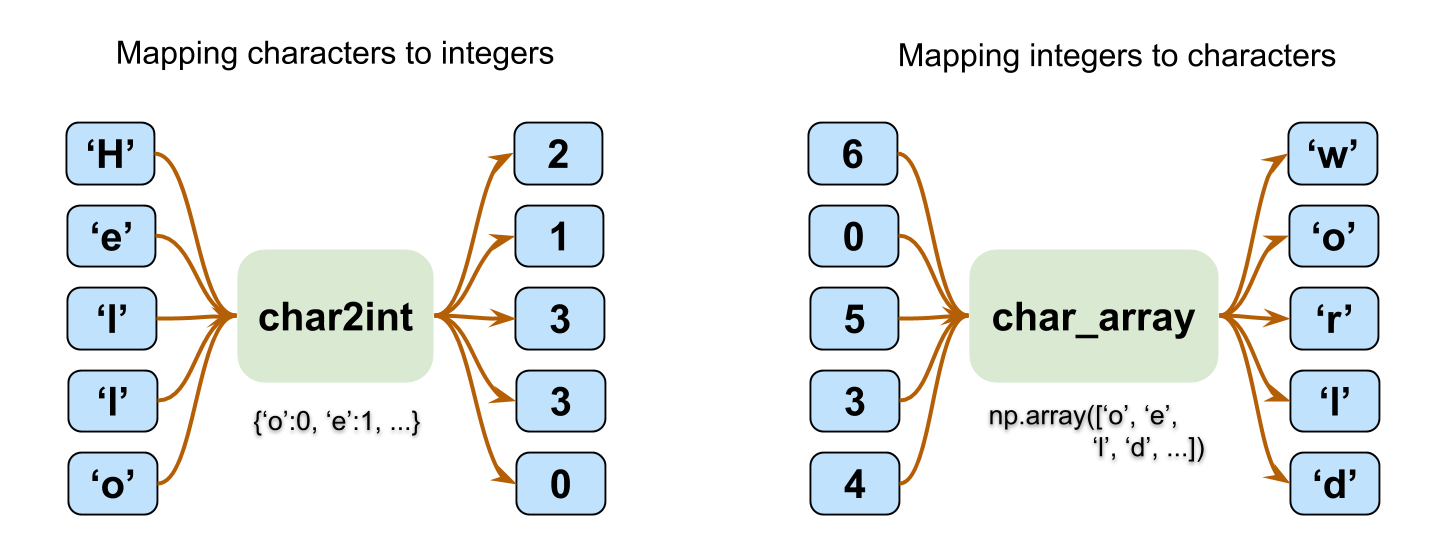

In [5]:
chars_sorted = sorted(char_set)
char2int = {ch:i for i,ch in enumerate(chars_sorted)}
char_array = np.array(chars_sorted)

text_encoded = np.array(
    [char2int[ch] for ch in text],
    dtype=np.int32)

print('Text encoded shape: ', text_encoded.shape)

print(text[:15], '     == Encoding ==> ', text_encoded[:15])
print(text_encoded[15:21], ' == Reverse  ==> ', ''.join(char_array[text_encoded[15:21]]))

Text encoded shape:  (1112350,)
THE MYSTERIOUS       == Encoding ==>  [44 32 29  1 37 48 43 44 29 42 33 39 45 43  1]
[33 43 36 25 38 28]  == Reverse  ==>  ISLAND


The NumPy array text_encoded contains the encoded values for all the characters in the text. Now, we will create a TensorFlow dataset from this array:

In [6]:
import tensorflow as tf


ds_text_encoded = tf.data.Dataset.from_tensor_slices(text_encoded)

for ex in ds_text_encoded.take(5):
    print('{} -> {}'.format(ex.numpy(), char_array[ex.numpy()]))

44 -> T
32 -> H
29 -> E
1 ->  
37 -> M


So far, we have created an iterable Dataset object for obtaining characters in the order they appear in the text. Now, let's step back and look at the big picture of what we are trying to do. For the text generation task, we can formulate the problem as a classification task.

Suppose we have a set of sequences of text characters that are incomplete, as shown in the following figure:
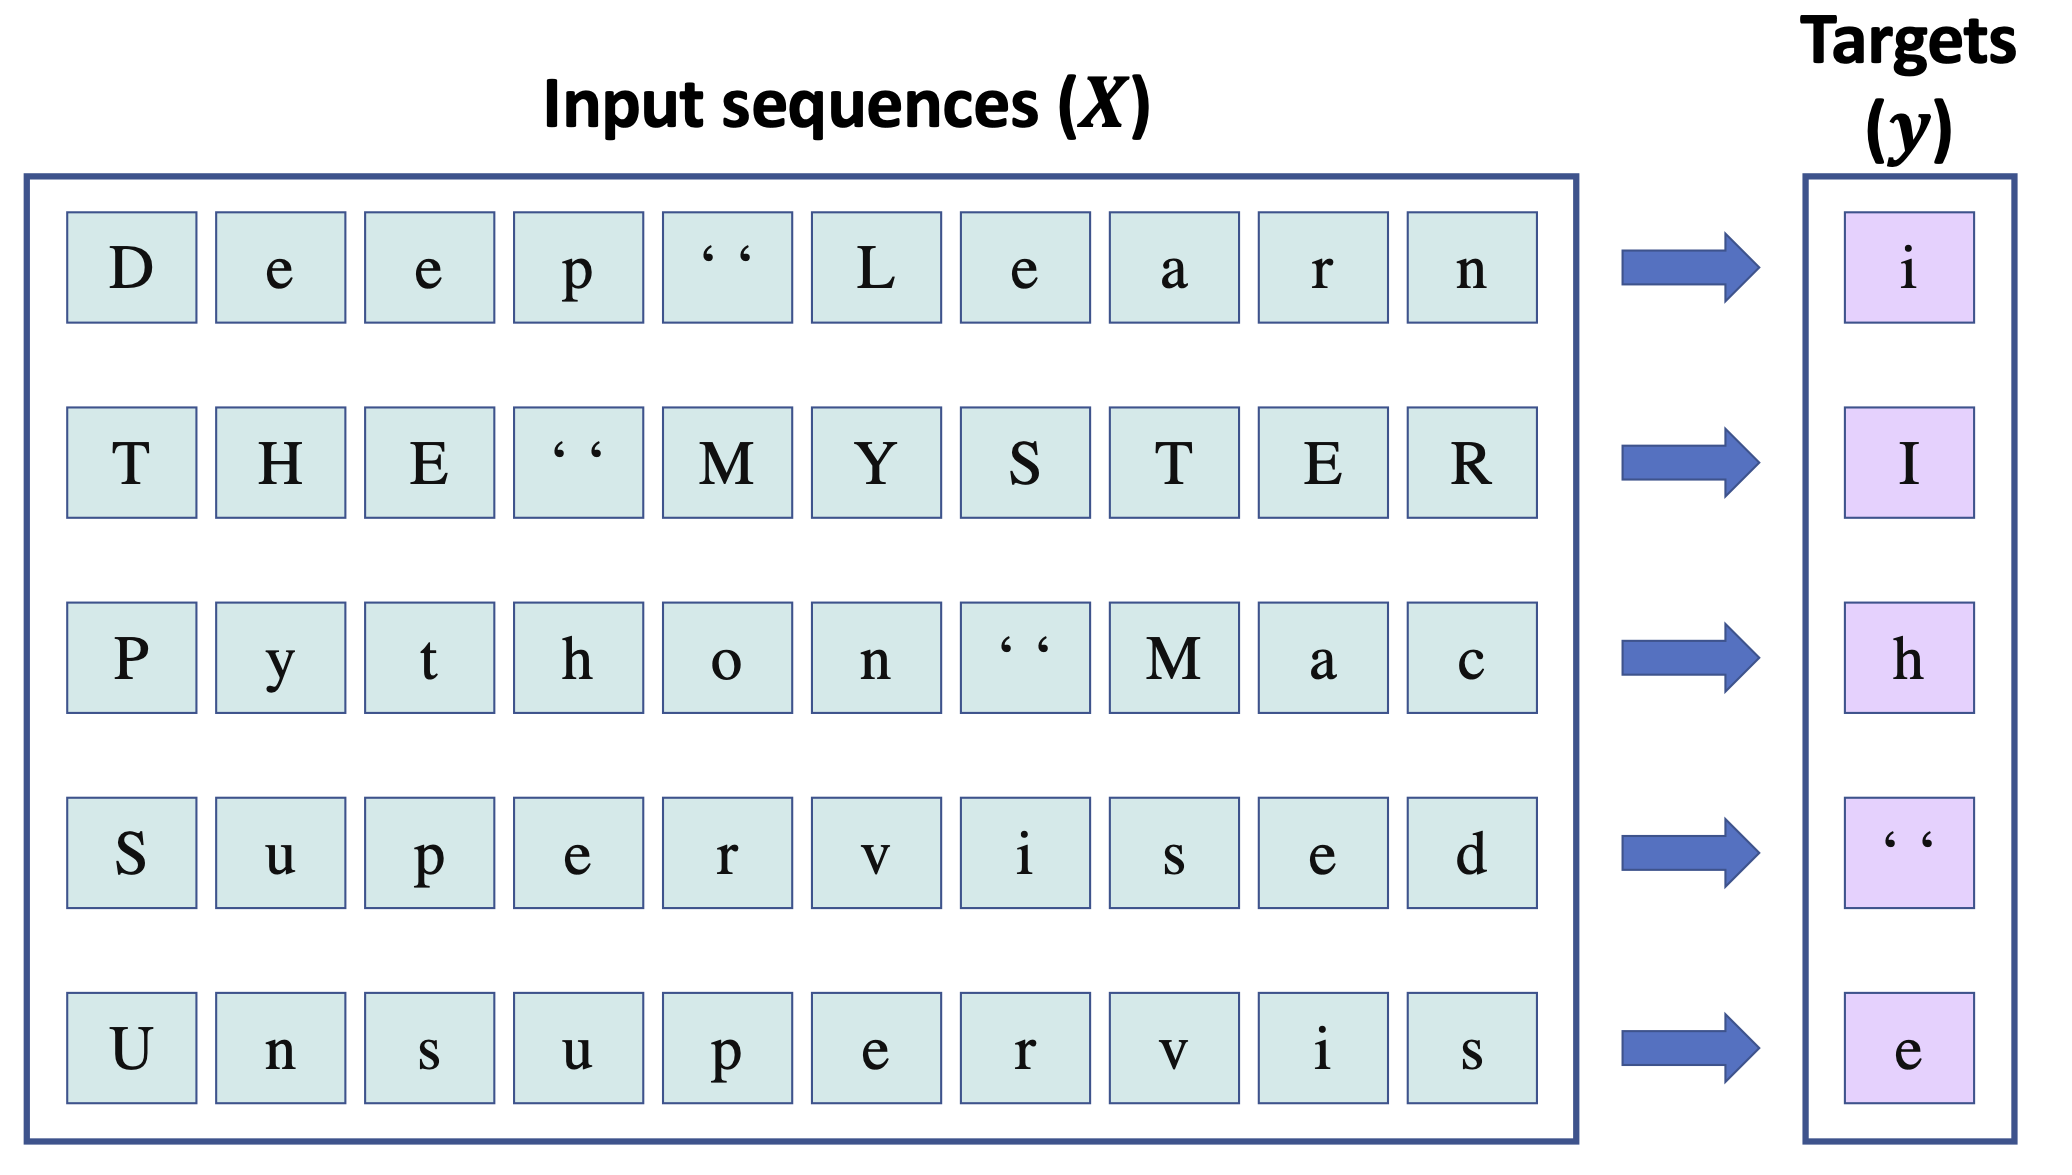

In the previous figure, we can consider the sequences shown in the left-hand box to be the input. In order to generate new text, our goal is to design a model that can predict the next character of a given input sequence, where the input sequence represents an incomplete text. For example, after seeing "Deep Learn", the model should predict "i" as the next character. Given that we have 80 unique characters, this problem becomes a multiclass classification task.




Starting with a sequence of length 1 (that is, one single letter), we can iteratively generate new text based on this multiclass classification approach, as illustrated in the following figure:

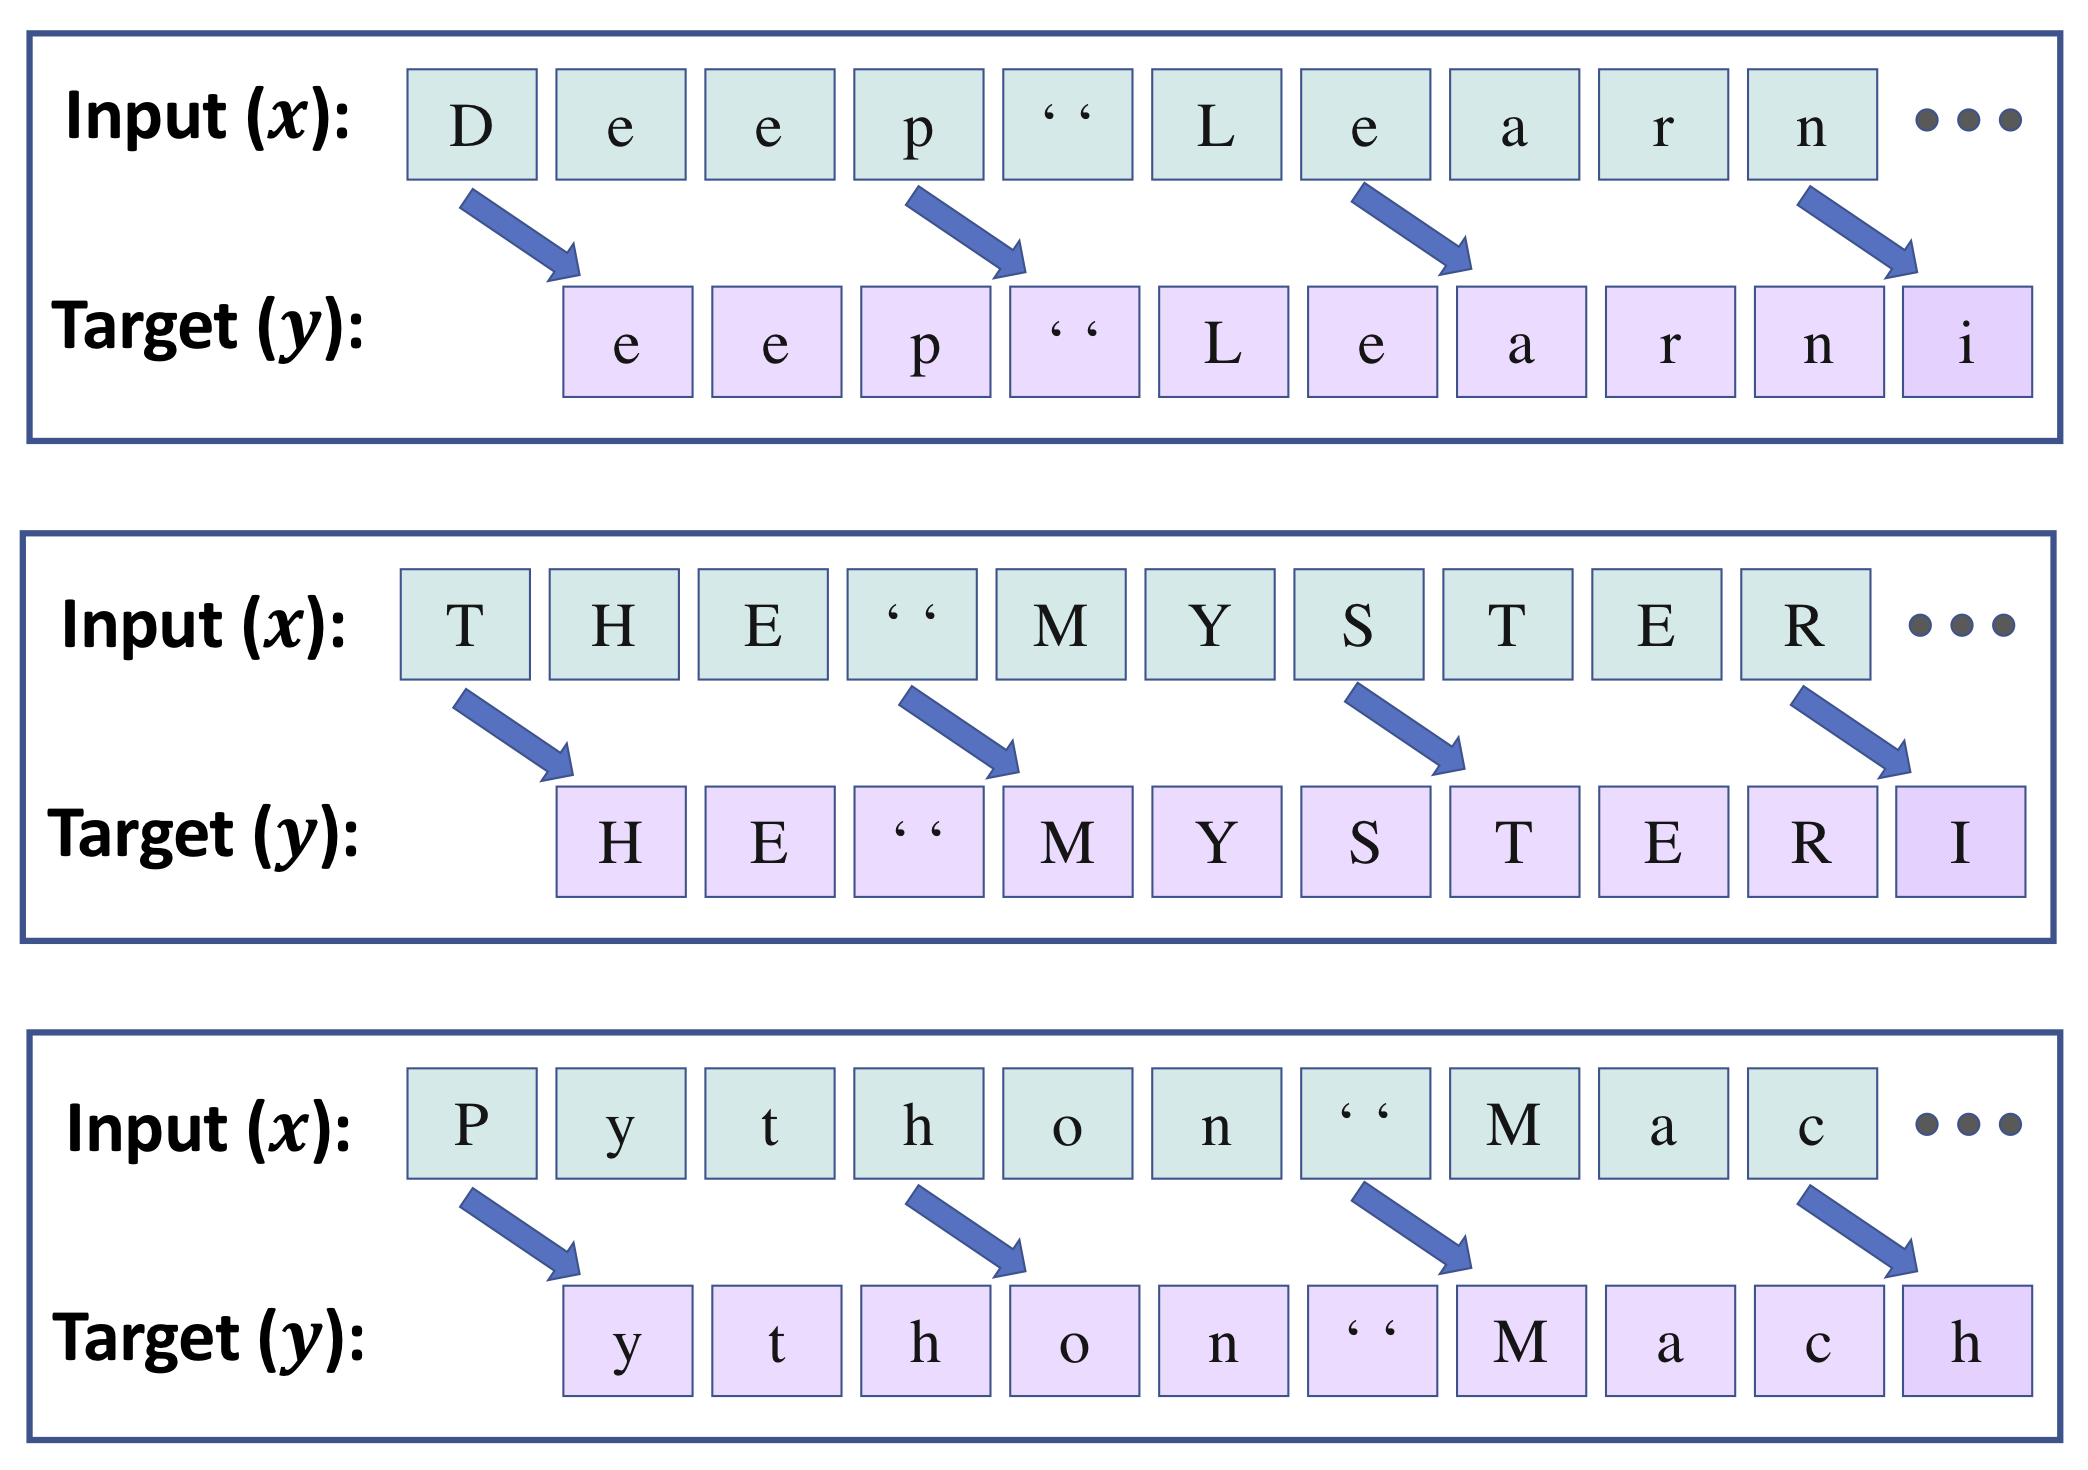

To implement the text generation task in TensorFlow, let's first clip the sequence length to 40. This means that the input tensor, x, consists of 40 tokens.

In practice, the sequence length impacts the quality of the generated text.

Longer sequences can result in more meaningful sentences. For shorter sequences, however, the model might focus on capturing individual words correctly, while ignoring the context for the most part.

Although longer sequences usually result in more meaningful sentences, as mentioned, for long sequences, the RNN model will have problems capturing long-term dependencies. Thus, in practice, finding a sweet spot and good value for the sequence length is a hyperparameter optimization problem, which we have to evaluate empirically. Here, we are going to choose 40, as it offers a good tradeoff.

As you can see in the previous figure, the inputs, x, and targets, y, are offset by one character. Hence, we will split the text into chunks of size 41: the first 40 characters will form the input sequence, x, and the last 40 elements will form the target sequence, y.

We have already stored the entire encoded text in its original order in a Dataset object, **ds_text_encoded**.

we will first use the **batch()** method to create text chunks consisting of 41 characters each. This means that we will set **batch_size=41**. We will further get rid of the last batch if it is shorter than 41 characters.

As a result, the new chunked dataset, named **ds_chunks**, will always contain sequences of size 41.

The 41-character chunks will then be used to construct the sequence x (that is, the input), as well as the sequence y (that is, the target), both of which will have 40 elements. For instance, sequence x will consist of the elements with indices [0, 1, …, 39]. Furthermore, since sequence y will be shifted by one position with respect to x, its corresponding indices will be [1, 2, …, 40]. Then, we will apply a transformation function using the map() method to separate the x and y sequences accordingly:

In [7]:
seq_length = 40
chunk_size = seq_length + 1

ds_chunks = ds_text_encoded.batch(chunk_size, drop_remainder=True)

## inspection:
for seq in ds_chunks.take(1):
    input_seq = seq[:seq_length].numpy()
    target = seq[seq_length].numpy()
    print(input_seq, ' -> ', target)
    print(repr(''.join(char_array[input_seq])),
          ' -> ', repr(''.join(char_array[target])))

[44 32 29  1 37 48 43 44 29 42 33 39 45 43  1 33 43 36 25 38 28  1  6  6
  6  0  0  0  0  0 40 67 64 53 70 52 54 53  1 51]  ->  74
'THE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced b'  ->  'y'


In [8]:
## define the function for splitting x & y
def split_input_target(chunk):
    input_seq = chunk[:-1]
    target_seq = chunk[1:]
    return input_seq, target_seq

ds_sequences = ds_chunks.map(split_input_target)

## inspection:
for example in ds_sequences.take(2):
    print(' Input (x):', repr(''.join(char_array[example[0].numpy()])))
    print('Target (y):', repr(''.join(char_array[example[1].numpy()])))
    print()

 Input (x): 'THE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced b'
Target (y): 'HE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced by'

 Input (x): ' Anthony Matonak, and Trevor Carlson\n\n\n\n'
Target (y): 'Anthony Matonak, and Trevor Carlson\n\n\n\n\n'



Finally, the last step in preparing the dataset is to divide this dataset into mini-batches. During the first preprocessing step to divide the dataset into batches, we created chunks of sentences. Each chunk represents one sentence, which corresponds to one training example. Now, we will shuffle the training examples and divide the inputs into mini-batches again; however, this time, each batch will contain multiple training examples:

In [9]:
# Batch size
BATCH_SIZE = 64
BUFFER_SIZE = 10000

tf.random.set_seed(1)
ds = ds_sequences.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)# drop_remainder=True)

ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 40), dtype=tf.int32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int32, name=None))>

Building a character-level RNN model

Now that the dataset is ready, building the model will be relatively straightforward. For code reusability, we will write a function, build_model, that defines an RNN model using the Keras Sequential class. Then, we can specify the training parameters and call that function to obtain an RNN model:

In [10]:
def build_model(vocab_size, embedding_dim, rnn_units):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim),
        tf.keras.layers.LSTM(
            rnn_units, return_sequences=True),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model


charset_size = len(char_array)
embedding_dim = 256
rnn_units = 512

tf.random.set_seed(1)

model = build_model(
    vocab_size = charset_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Notice that the LSTM layer in this model has the output shape (None, None, 512), which means the output of LSTM is rank 3. The first dimension stands for the number of batches, the second dimension for the output sequence length, and the last dimension corresponds to the number of hidden units. The reason for having rank-3 output from the LSTM layer is because we have specified return_sequences=True when defining our LSTM layer. A fully connected layer (Dense) receives the output from the LSTM cell and computes the logits for each element of the output sequences. As a result, the final output of the model will be a rank-3 tensor as well.

Furthermore, we specified activation=None for the final fully connected layer. The reason for this is that we will need to have the logits as outputs of the model so that we can sample from the model predictions in order to generate new text. We will get to this sampling part later. For now, let's train the model:

In [11]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True
    ))

model.fit(ds, epochs=20)

Epoch 1/20
260/424 ━━━━━━━━━━━━━━━━━━━━ 2:21 863ms/step - loss: 2.7735

KeyboardInterrupt: 

Now, we can evaluate the model to generate new text, starting with a given short string. In the next section, we will define a function to evaluate the trained model.

**Evaluation phase generating new text passages**

The RNN model we trained returns the logits of size 80 for each unique character. These logits can be readily converted to probabilities, via the **softmax** function, that a particular character will be encountered as the next character. To predict the next character in the sequence, we can simply select the element with the maximum logit value, which is equivalent to selecting the character with the highest probability. However, instead of always selecting the character with the highest likelihood, we want to (randomly) sample from the outputs; otherwise, the model will always produce the same text. TensorFlow already provides a function, tf.random.categorical(), which we can use to draw random samples from a categorical distribution. To see how this works, let's generate some random samples from three categories [0, 1, 2], with input logits [1, 1, 1].


In [ ]:
tf.random.set_seed(1)

logits = [[1.0, 1.0, 1.0]]
print('Probabilities:', tf.math.softmax(logits).numpy()[0])

samples = tf.random.categorical(
    logits=logits, num_samples=10)
tf.print(samples.numpy())

As you can see, with the given logits, the categories have the same probabilities (that is, equiprobable categories). Therefore, if we use a large sample size (), we would expect the number of occurrences of each category to reach  of the sample size. If we change the logits to [1, 1, 3], then we would expect to observe more occurrences for category 2 (when a very large number of examples are drawn from this distribution):

In [ ]:
tf.random.set_seed(1)

logits = [[1.0, 1.0, 3.0]]
print('Probabilities:', tf.math.softmax(logits).numpy()[0])

samples = tf.random.categorical(
    logits=logits, num_samples=10)
tf.print(samples.numpy())

Using tf.random.categorical, we can generate examples based on the logits computed by our model. We define a function, sample(), that receives a short starting string, starting_str, and generate a new string, generated_str, which is initially set to the input string. Then, a string of size max_input_length is taken from the end of generated_str and encoded to a sequence of integers, encoded_input. The encoded_input is passed to the RNN model to compute the logits. Note that the output from the RNN model is a sequence of logits with the same length as the input sequence, since we specified return_sequences=True for the last recurrent layer of our RNN model. Therefore, each element in the output of the RNN model represents the logits (here, a vector of size 80, which is the total number of characters) for the next character after observing the input sequence by the model.

Here, we only use the last element of the output logits (that is, ), which is passed to the tf.random.categorical() function to generate a new sample. This new sample is converted to a character, which is then appended to the end of the generated string, generated_text, increasing its length by 1. Then, this process is repeated, taking the last max_input_length number of characters from the end of the generated_str, and using that to generate a new character until the length of the generated string reaches the desired value. The process of consuming the generated sequence as input for generating new elements is called auto-regression.

The code for the sample() function is as follows:

In [ ]:
def sample(model, starting_str,
           len_generated_text=500,
           max_input_length=40,
           scale_factor=1.0):
    encoded_input = [char2int[s] for s in starting_str]
    encoded_input = tf.reshape(encoded_input, (1, -1))

    generated_str = starting_str

    model.reset_states()
    for i in range(len_generated_text):
        logits = model(encoded_input)
        logits = tf.squeeze(logits, 0)

        scaled_logits = logits * scale_factor
        new_char_indx = tf.random.categorical(
            scaled_logits, num_samples=1)

        new_char_indx = tf.squeeze(new_char_indx)[-1].numpy()

        generated_str += str(char_array[new_char_indx])

        new_char_indx = tf.expand_dims([new_char_indx], 0)
        encoded_input = tf.concat(
            [encoded_input, new_char_indx],
            axis=1)
        encoded_input = encoded_input[:, -max_input_length:]

    return generated_str

tf.random.set_seed(1)
print(sample(model, starting_str='The island'))

The island is open he heard the victory of the
Mercy, and brought it into them, and they no longer continue, some on the little man of the felting circle of slopes.

The engineer troused, he could not find our companions.



Chapter 11

At this position, he might just as if his first true to be finished, and he
though not more I can this teles.”

“Why shall fear line,” answered the reporter, “what a disposal silence was advanced with them, and in masterspon.

Before three heights of the
Frenchant Heights 


As you can see, the model generates mostly correct words, and, in some cases, the sentences are partially meaningful. You can further tune the training parameters, such as the length of input sequences for training, the model architecture, and sampling parameters (such as max_input_length).

Furthermore, in order to control the predictability of the generated samples (that is, generating text following the learned patterns from the training text versus adding more randomness), the logits computed by the RNN model can be scaled before being passed to tf.random.categorical() for sampling. The scaling factor, , can be interpreted as the inverse of the temperature in physics. Higher temperatures result in more randomness versus more predictable behavior at lower temperatures. By scaling the logits with , the probabilities computed by the softmax function become more uniform, as shown in the following code:

**Predictability Vs Randomness**

As you can see, scaling the logits by scaling (alpha) = 0.1  results in near-uniform probabilities [0.31, 0.31, 0.38].

In [ ]:
logits = np.array([[1.0, 1.0, 3.0]])

print('Probabilities before scaling:        ', tf.math.softmax(logits).numpy()[0])

print('Probabilities after scaling with 0.5:', tf.math.softmax(0.5*logits).numpy()[0])

print('Probabilities after scaling with 0.1:', tf.math.softmax(0.1*logits).numpy()[0])

Probabilities before scaling:         [0.10650698 0.10650698 0.78698604]
Probabilities after scaling with 0.5: [0.21194156 0.21194156 0.57611688]
Probabilities after scaling with 0.1: [0.31042377 0.31042377 0.37915245]


Now, we can compare the generated text with scaling (alpha) = 2.0 and scaling (alpha) = 0.5, as shown in the following points:

In [ ]:
tf.random.set_seed(1)
print(sample(model, starting_str='The island',
             scale_factor=2.0))

The island was so as to discover the position of the darkness there.

The ground was about to death the man had been so struck the colonists have been able to speak a little by returning to the corral. The next day the summer heard might be supposed that the first time on the shore, and the captain proved the cart of the colonists the stranger was towards the
colonists, who were very simple to salm a little beach of the corral, the settlers had already proceeded towards the rocks, and they had already sti


In [ ]:
tf.random.set_seed(1)
print(sample(model, starting_str='The island',
             scale_factor=0.5))

The island
happilid a drems parts,
withmests? Barmected safed, Lindoency-islew.

Top,
HiqualshE As culting among Promotion.”
Criflies verdood. ven,
had
lastly vivit!
Monsh!

Coar swimmemsly above Ony indident
qumbtelfisking
forty-8ther.

These trenimostly penered; theanesemonerg.
-gamisw, open in his sudden valarmania
him leare
LebThoastor LarbodDeri’s raying
anchors, unvorunormes an hour, butlo Life polpue escaped by twelve wedcousment.”

Can ear1-tive,” ed Pencroft, “who cinnot into nacuounls of
severe 


# **Introduction to Transformers**

So far, we implemented RNN model and discussed its application for NLP.

A new architecutre has recently emerged that has shown to outperform the RNN
based sequence to sequence model in several NLP tasks.

This new architecuture is called as transformer architure.

Transformers have revolutionized NLP and have been at the forefront of many impressive applications rangining from automated language translation to modeling fundamental properties of protien sequences and creating an AI that helps people write code and so many other applications.



Assume we have an input sentence that we encoded via a dictionary, which maps the words to integers as discussed in the RNN chapter:

In [ ]:
import torch


# input sequence / sentence:
#  "Can you help me to translate this sentence"

sentence = torch.tensor(
    [0, # can
     7, # you
     1, # help
     2, # me
     5, # to
     6, # translate
     4, # this
     3] # sentence
)

sentence

tensor([0, 7, 1, 2, 5, 6, 4, 3])

Next, assume we have an embedding of the words, i.e., the words are represented as real vectors.

Since we have 8 words, there will be 8 vectors. Each vector is 16-dimensional:

In [ ]:
torch.manual_seed(123)
embed = torch.nn.Embedding(10, 16)
embedded_sentence = embed(sentence).detach()
embedded_sentence.shape

torch.Size([8, 16])

- The goal is to compute the context vectors $\boldsymbol{z}^{(i)}=\sum_{j=1}^{T} \alpha_{i j} \boldsymbol{x}^{(j)}$, which involve attention weights $\alpha_{i j}$.
- In turn, the attention weights $\alpha_{i j}$ involve the $\omega_{i j}$ values
- Let's start with the $\omega_{i j}$'s first, which are computed as dot-products:

$$\omega_{i j}=\boldsymbol{x}^{(i)^{\top}} \boldsymbol{x}^{(j)}$$



In [ ]:
omega = torch.empty(8, 8)

for i, x_i in enumerate(embedded_sentence):
    for j, x_j in enumerate(embedded_sentence):
        omega[i, j] = torch.dot(x_i, x_j)

- Actually, let's compute this more efficiently by replacing the nested for-loops with a matrix multiplication:

In [ ]:
omega_mat = embedded_sentence.matmul(embedded_sentence.T)

In [ ]:
torch.allclose(omega_mat, omega)

True

- Next, let's compute the attention weights by normalizing the "omega" values so they sum to 1

$$\alpha_{i j}=\frac{\exp \left(\omega_{i j}\right)}{\sum_{j=1}^{T} \exp \left(\omega_{i j}\right)}=\operatorname{softmax}\left(\left[\omega_{i j}\right]_{j=1 \ldots T}\right)$$

$$\sum_{j=1}^{T} \alpha_{i j}=1$$

In [ ]:
import torch.nn.functional as F

attention_weights = F.softmax(omega, dim=1)
attention_weights.shape

torch.Size([8, 8])

- We can conform that the columns sum up to one:

In [ ]:
attention_weights.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

- Now that we have the attention weights, we can compute the context vectors $\boldsymbol{z}^{(i)}=\sum_{j=1}^{T} \alpha_{i j} \boldsymbol{x}^{(j)}$, which involve attention weights $\alpha_{i j}$
- For instance, to compute the context-vector of the 2nd input element (the element at index 1), we can perform the following computation:

In [ ]:
x_2 = embedded_sentence[1, :]
context_vec_2 = torch.zeros(x_2.shape)
for j in range(8):
    x_j = embedded_sentence[j, :]
    context_vec_2 += attention_weights[1, j] * x_j

context_vec_2

tensor([-9.3975e-01, -4.6856e-01,  1.0311e+00, -2.8192e-01,  4.9373e-01,
        -1.2896e-02, -2.7327e-01, -7.6358e-01,  1.3958e+00, -9.9543e-01,
        -7.1287e-04,  1.2449e+00, -7.8077e-02,  1.2765e+00, -1.4589e+00,
        -2.1601e+00])

- Or, more effiently, using linear algebra and matrix multiplication:

In [ ]:
context_vectors = torch.matmul(
        attention_weights, embedded_sentence)


torch.allclose(context_vec_2, context_vectors[1])

True